In [1]:
library(dplyr)
library(magrittr)
library(data.table)
library(ggplot2)
library(ggdist)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘data.table’




The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
load("../input/yield-curve-modeling-nelson-siegel-svensson/myworkspace.RData")

In [3]:
tsmodel <- tsDyn::lineVar(mybetas_joint, lag = 1, include = "none", model = "VAR", I = "diff")
rinnov <- ghyp::fit.tmv(tsmodel$residuals |> scale(center = FALSE, scale = FALSE), silent = TRUE)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [4]:
NSIM <- 1000
cl <- ifelse(NSIM < 5001, 1, 4)

set.seed(776655)
tictoc::tic()

betasims <- pbapply::pblapply(1:NSIM, FUN = function(i, n.ahead = 120) {
  betasim <- tsDyn::VAR.sim(tsmodel$coefficients, n = n.ahead, lag = 1, include = "none", starting = mybetas_joint |> diff() |> tail(1), innov = ghyp::rghyp(n = n.ahead, rinnov), show.parMat = FALSE, returnStarting = FALSE) %>%
    rbind(mybetas_joint |> tail(1), .) |>
    apply(2, cumsum)
  rownames(betasim) <- paste0("T+", seq_len(n.ahead + 1) - 1)
  return(betasim)
}, cl = cl)

tictoc::toc()

5.405 sec elapsed


In [5]:
ycsims_open  <- betasims |> purrr::map(\(b, B)head(b, -1) %*% t(B), B = msv_mat_mod(durs = list(eurgovy = relevantdurs, ustrsy = relevantdurs), taus = list(eurgovy = opt_joint_taus_mod[1:2], ustrsy = opt_joint_taus_mod[3:4])))
ycsims_close <- betasims |> purrr::map(\(b, B)tail(b, -1) %*% t(B), B = msv_mat_mod(durs = list(eurgovy = relevantdurs - 1 / 12, ustrsy = relevantdurs - 1 / 12), taus = list(eurgovy = opt_joint_taus_mod[1:2], ustrsy = opt_joint_taus_mod[3:4])))

px_open  <- ycsims_open |> lapply(\(inp)mapply(\(x,y)exp(-y*x/100) |> setNames(rownames(inp)), as.data.frame(inp), rep(relevantdurs, 2)))
px_close <- ycsims_close |>lapply(\(inp)mapply(\(x,y)exp(-y*x/100) |> setNames(rownames(inp)), as.data.frame(inp), rep(relevantdurs, 2)))

total_rets <- purrr::map2(px_open, px_close, \(x, y)(y / x - 1) |> set_colnames(colnames(x)))
total_rets_cumul <- total_rets |> purrr::map(\(x)apply(x, 2, \(r)cumprod(1 + r) - 1))

In [6]:
tictoc::tic()

ycsims_tidy <- (
    ycsims_open |> lapply(\(df)as.data.table(df, keep.rownames="period") |> melt(id.vars="period", value.name="y", variable.name="tenor")) |> 
      rbindlist(idcol = "sim_id")
) |> as_tibble() |>
    mutate(curve = stringr::str_extract(tenor , "^(.+?)_", group = 1) |> toupper(),
           dur = stringr::str_extract(tenor , "_(.+?)$", group = 1) |> as.numeric()
          )

tictoc::toc()

4.541 sec elapsed


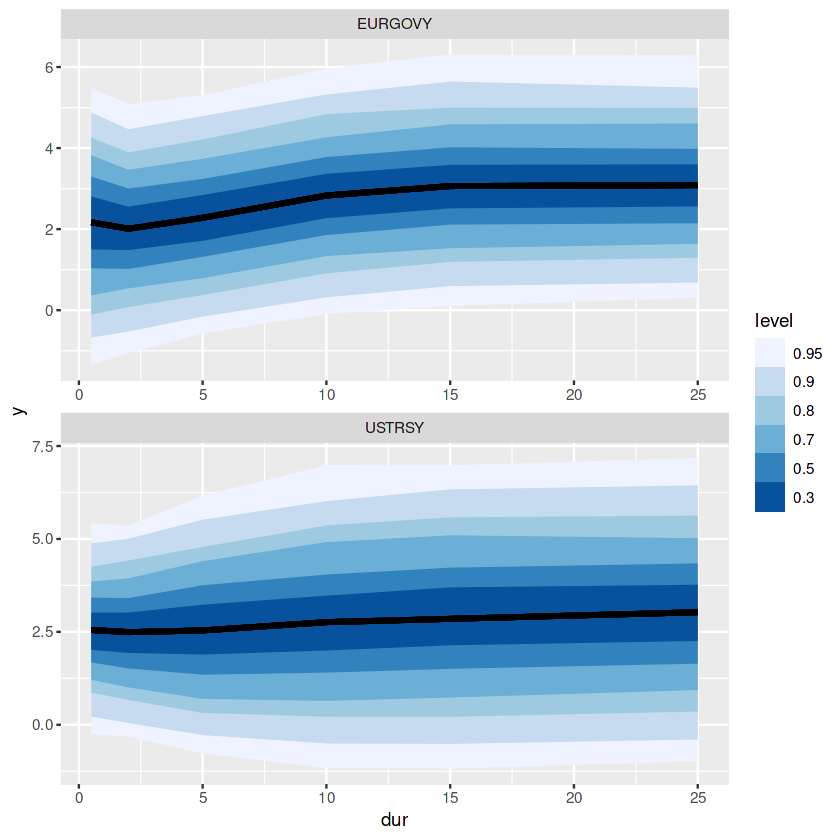

In [7]:
ycsims_tidy |> filter(period == "T+36") |> ggplot(aes(x = dur, y = y)) + 
    stat_lineribbon(.width = c(0.3, 0.5, 0.7, 0.8, 0.9, 0.95)) + 
    scale_fill_brewer() + 
    facet_wrap(~curve, ncol = 1, scales = "free")# + xlim(c(0.5, 10))

In [8]:
tictoc::tic()

total_rets_horizon_tidy <- (
    total_rets_cumul |> lapply(\(df)as.data.table(df, keep.rownames="period") |> melt(id.vars="period", value.name="r", variable.name="tenor")) |> 
      rbindlist(idcol = "sim_id")
) |> as_tibble() |>
    mutate(curve = stringr::str_extract(tenor , "^(.+?)_", group = 1) |> toupper(),
           dur = stringr::str_extract(tenor , "_(.+?)$", group = 1) |> as.numeric()
          )

tictoc::toc()

3.937 sec elapsed


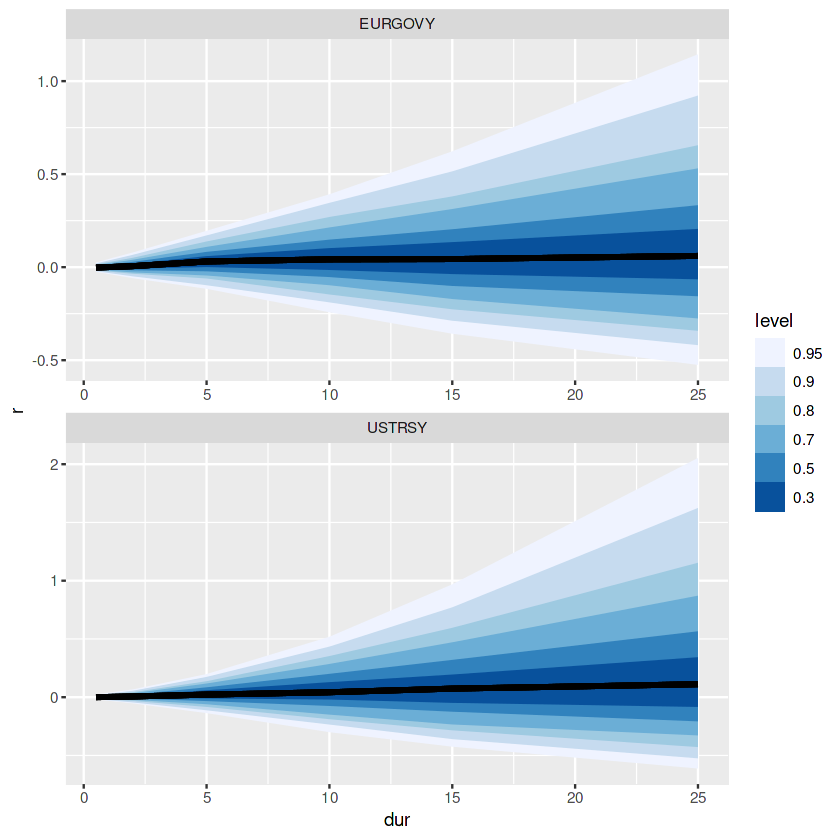

In [9]:
total_rets_horizon_tidy |> filter(period == "T+36") |> ggplot(aes(x = dur, y = r)) + 
    stat_lineribbon(.width = c(0.3, 0.5, 0.7, 0.8, 0.9, 0.95)) + 
    scale_fill_brewer() + 
    facet_wrap(~curve, ncol = 1, scales = "free")# + xlim(c(0.5, 10))

In [10]:
rawmldata <- vroom::vroom("../input/yield-curve-factor-forecasting-ml-in-python/mybetas_joint_ml_sims.csv")

Rows: 28800 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): variable
dbl  (2): sim_id, value
date (1): Date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
mldata <- rawmldata |> group_by(sim_id) |> group_split(.keep = FALSE) |>
    purrr::map(~tidyr::pivot_wider(.x, id_cols=Date, names_from=variable, values_from=value) |> xts::as.xts() |> as.matrix()) |>
    purrr::map(~rbind(mybetas_joint |> tail(1), .x))

In [12]:
mlsims_open  <- mldata |> purrr::map(\(b, B)head(b, -1) %*% t(B), B = msv_mat_mod(durs = list(eurgovy = relevantdurs, ustrsy = relevantdurs), taus = list(eurgovy = opt_joint_taus_mod[1:2], ustrsy = opt_joint_taus_mod[3:4])))
mlsims_close <- mldata |> purrr::map(\(b, B)tail(b, -1) %*% t(B), B = msv_mat_mod(durs = list(eurgovy = relevantdurs - 1 / 12, ustrsy = relevantdurs - 1 / 12), taus = list(eurgovy = opt_joint_taus_mod[1:2], ustrsy = opt_joint_taus_mod[3:4])))

mlpx_open  <- mlsims_open |> lapply(\(inp)mapply(\(x,y)exp(-y*x/100) |> setNames(rownames(inp)), as.data.frame(inp), rep(relevantdurs, 2)))
mlpx_close <- mlsims_close |>lapply(\(inp)mapply(\(x,y)exp(-y*x/100) |> setNames(rownames(inp)), as.data.frame(inp), rep(relevantdurs, 2)))

mltotal_rets <- purrr::map2(mlpx_open, mlpx_close, \(x, y)(y / x - 1) |> set_colnames(colnames(x)))
mltotal_rets_cumul <- mltotal_rets |> purrr::map(\(x)apply(x, 2, \(r)cumprod(1 + r) - 1))

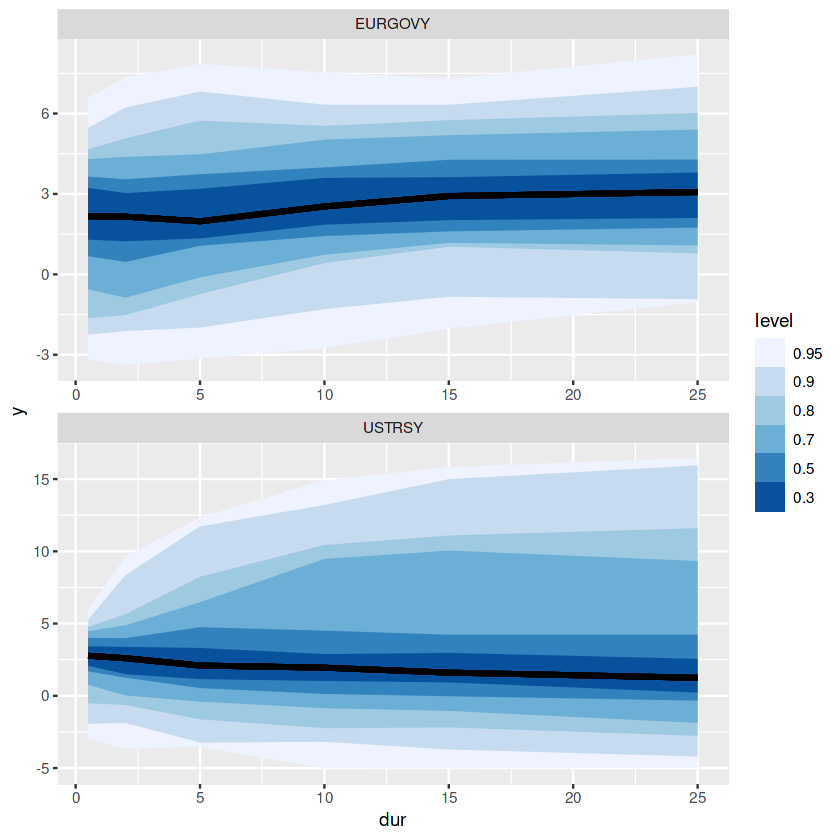

In [13]:
mlsims_tidy <- (
    mlsims_open |> lapply(\(df)as.data.table(df, keep.rownames="period") |> melt(id.vars="period", value.name="y", variable.name="tenor")) |> 
      rbindlist(idcol = "sim_id")
) |> as_tibble() |>
    mutate(curve = stringr::str_extract(tenor , "^(.+?)_", group = 1) |> toupper(),
           dur = stringr::str_extract(tenor , "_(.+?)$", group = 1) |> as.numeric()
          )

mlsims_tidy |> filter(period == "2027-12-01") |> ggplot(aes(x = dur, y = y)) + 
    stat_lineribbon(.width = c(0.3, 0.5, 0.7, 0.8, 0.9, 0.95)) + 
    scale_fill_brewer() + 
    facet_wrap(~curve, ncol = 1, scales = "free")

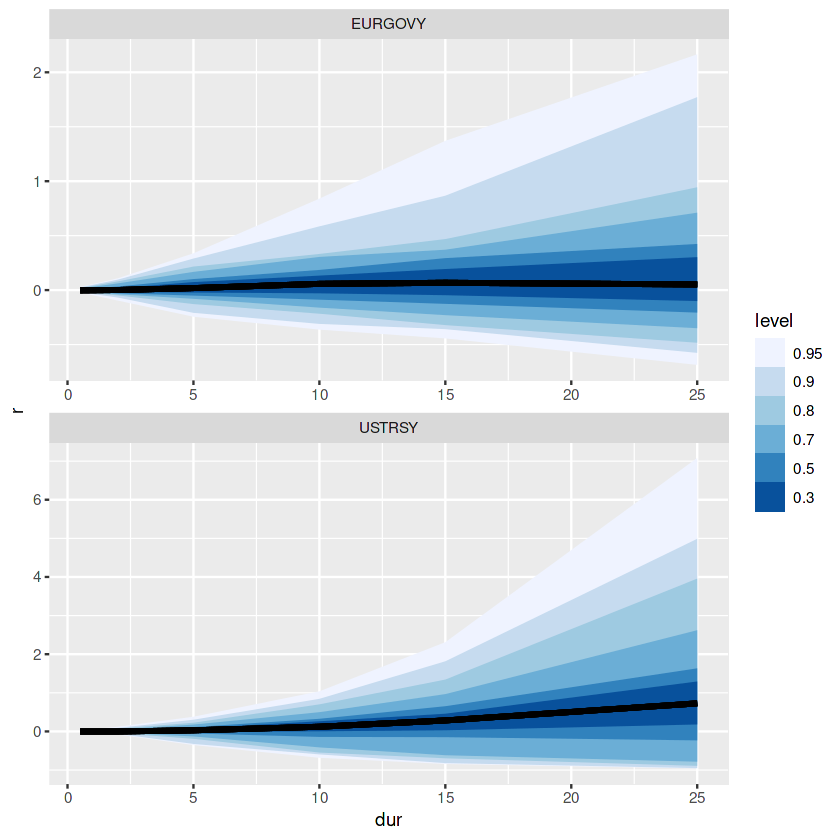

In [14]:
mltotal_rets_horizon_tidy <- (
    mltotal_rets_cumul |> lapply(\(df)as.data.table(df, keep.rownames="period") |> melt(id.vars="period", value.name="r", variable.name="tenor")) |> 
      rbindlist(idcol = "sim_id")
) |> as_tibble() |>
    mutate(curve = stringr::str_extract(tenor , "^(.+?)_", group = 1) |> toupper(),
           dur = stringr::str_extract(tenor , "_(.+?)$", group = 1) |> as.numeric()
          )

mltotal_rets_horizon_tidy |> filter(period == "2028-01-01") |> ggplot(aes(x = dur, y = r)) + 
    stat_lineribbon(.width = c(0.3, 0.5, 0.7, 0.8, 0.9, 0.95)) + 
    scale_fill_brewer() + 
    facet_wrap(~curve, ncol = 1, scales = "free")# + xlim(c(0.5, 10))